## 🔧 Environment Setup and Imports

This cell sets up the Python environment for the project:

- Imports core libraries: NumPy, Pandas, OpenCV, PIL
- Loads visualization tools: Seaborn and Matplotlib
- Imports machine learning utilities from `sklearn` and PyTorch
- Sets a consistent random seed for reproducibility
- Defines the default device (GPU if available, else CPU)
- Configures a custom color palette and plot size for cleaner visualizations


In [1]:
# Install any missing packages
!pip install opencv-python-headless seaborn

# Imports and configuration
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

import torch, torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline

# Set Seaborn visual style
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 15, 10

# Set seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## 📁 Dataset Setup and Folder Labeling

This section of the code:

- Loads the training dataset and assigns labels to each class based on the folder names:
  - `buildings = 0`
  - `forest = 1`
  - `glacier = 2`
  - `mountain = 3`
  - `sea = 4`
  - `street = 5`
- Uses the `glob` function to find all subfolders under the `seg_train` folder and sorts them.
- Verifies that there are 6 folders (representing the 6 classes).


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


In [4]:
from google.colab import files
files.upload()  # upload kaggle.json manually when prompted

# Move it to the right location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [5]:
import kagglehub

path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/intel-image-classification


In [6]:
from glob import glob

train_folders = sorted(glob(f"{path}/seg_train/seg_train/*"))
print("Total class folders found:", len(train_folders))



Total class folders found: 6


In [7]:
#Load & View Images
#Here we build 3 helpers to load and view images

def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    if resize:
        img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)

    return img

def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')

def show_sign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    images = images.permute(0, 3, 1, 2)
    grid_img = torchvision.utils.make_grid(images, nrow = 11)
    plt.figure(figsize = (24, 12))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

<ipython-input-7-7cb5b87a649a>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  images = torch.as_tensor(images)


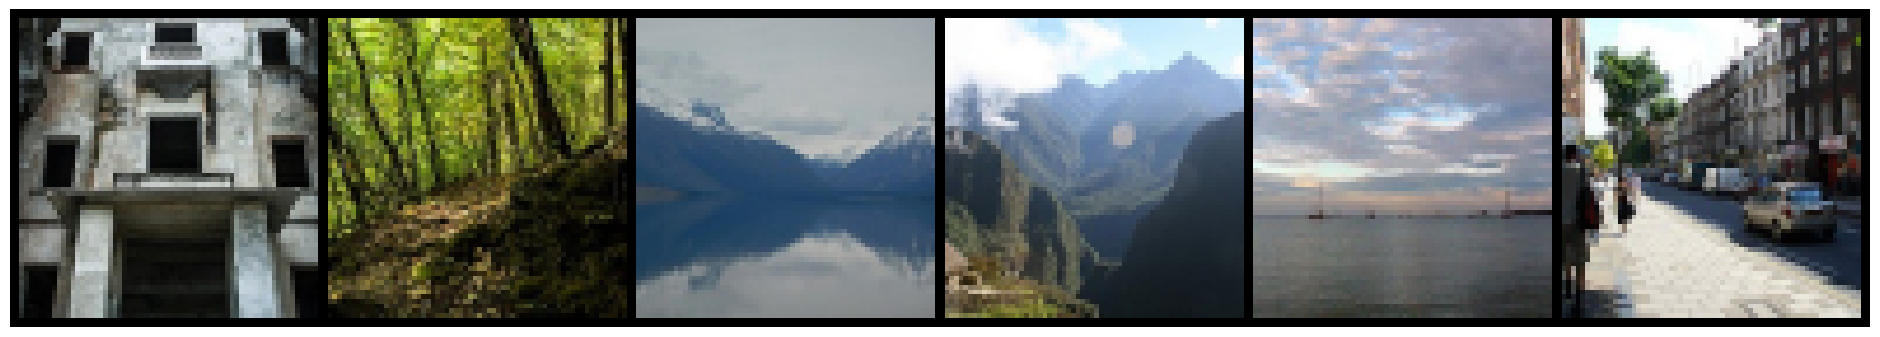

In [8]:
#All Classes.
sample_images = [np.random.choice(glob(f'{tf}/*jpg')) for tf in train_folders]
show_sign_grid(sample_images)

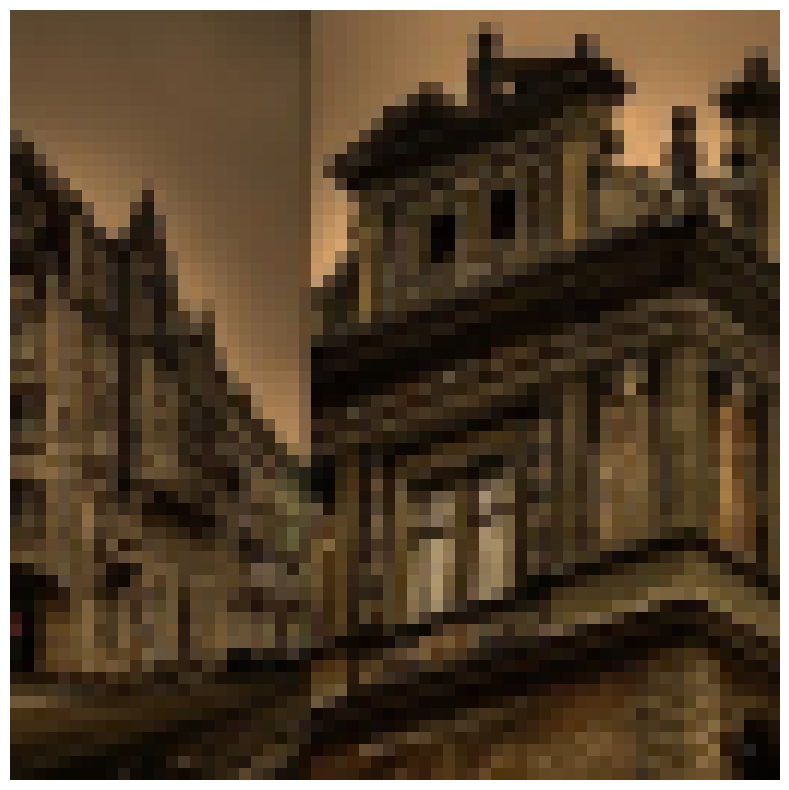

In [9]:
#Buildings Class.
img_path = glob(f'{train_folders[0]}/*jpg')[1]
show_image(img_path)

In [10]:
#Class Classification.
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

class_indices = [0, 1, 2, 3, 4, 5]

In [11]:
#Train & Valid Directory.
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val']

for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

We are going to reserve 80% for train and 20% for validation for each class, then copy them to the correct folder


In [12]:

#Class Distribution & Split.
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{train_folders[cls_index]}/*jpg')) #train_folders[cls_index]를 image_paths에 저장.
    class_name = class_names[i] #class_names[i]를 class_name에 저장.
    print(f'{class_name}: {len(image_paths)}') #class_name과 len(image_paths)을 pirnt.
    np.random.shuffle(image_paths)

    ds_split = np.split(
        image_paths,
        indices_or_sections = [int(.8 * len(image_paths)), int(.9 * len(image_paths))]
    )

    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


In [13]:
#Transforms.
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size = 256),
    T.RandomRotation(degrees = 15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)]),
    'val': T.Compose([
    T.Resize(size = 256),
    T.CenterCrop(size = 224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)]),
}

In [14]:
#Image Datasets.
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

#Data Loaders.
data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) for d in DATASETS
}

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [15]:
print(len(data_loaders['train']))


2806


In [16]:
#Dataset Sizes.
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 11224, 'val': 1402}

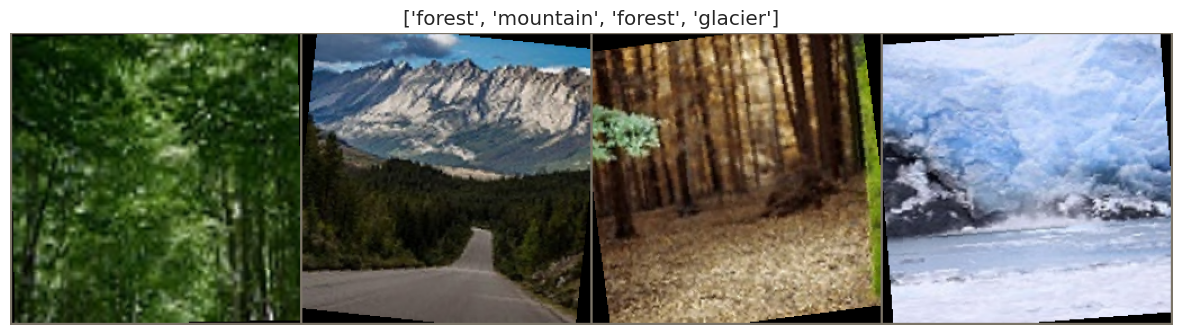

In [17]:
#Transformations Sample Images.
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

##Using pretrained model to classify the images
We will use the pre-trained ResNet to classify this images

We will import the model (import all weights and arch except we will change the output layer as number of output class is different from ResNet dataset)
- Convert it into training mode
- Train the model on new data
- Evaluate


In [18]:
#Create Model
def create_model(n_classes):
    #resnet34, resnet152, wide_resnet101_2, resnext101_32x8d
    model = models.resnext101_32x8d(pretrained = True)

    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

    return model.to(device)

In [19]:
base_model = create_model(len(class_names))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:02<00:00, 176MB/s]


In [20]:
base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [21]:

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train() #Convert to train mode
    losses = []
    correct_predictions = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device) #Push array to gpu
        labels = labels.to(device)

        outputs = model(inputs) #get prob of output per class

        _, preds = torch.max(outputs, dim=1) # get max of pred
        loss = loss_fn(outputs, labels) # get loss

        correct_predictions += torch.sum(preds==labels)

        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() #Evaluation mode

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds==labels)

            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:

def train_model(model, data_loaders, dataset_sizes, device, n_epochs=5):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)

    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(model, data_loaders['train'], loss_fn,
                                            optimizer, device, scheduler, dataset_sizes['train'])

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(model, data_loaders['val'], loss_fn, device, dataset_sizes['val'])

        print(f'Val loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

    print(f'Best val accuracy: {best_accuracy}')

    model.load_state_dict(torch.load('best_model_state.bin'))

    return model, history

In [23]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device, n_epochs=1)

Epoch 1/1
----------
Train loss 0.6959576255861598 accuracy 0.7455452601568069
Val loss 0.22529962770538034 accuracy 0.9215406562054208

Best val accuracy: 0.9215406562054208
CPU times: user 11min 9s, sys: 5.72 s, total: 11min 15s
Wall time: 11min 35s


### Testing the model

In [24]:
test_folders = sorted(glob(f"{path}/seg_test/seg_test/*"))
print("Total class folders found:", len(test_folders))

Total class folders found: 6


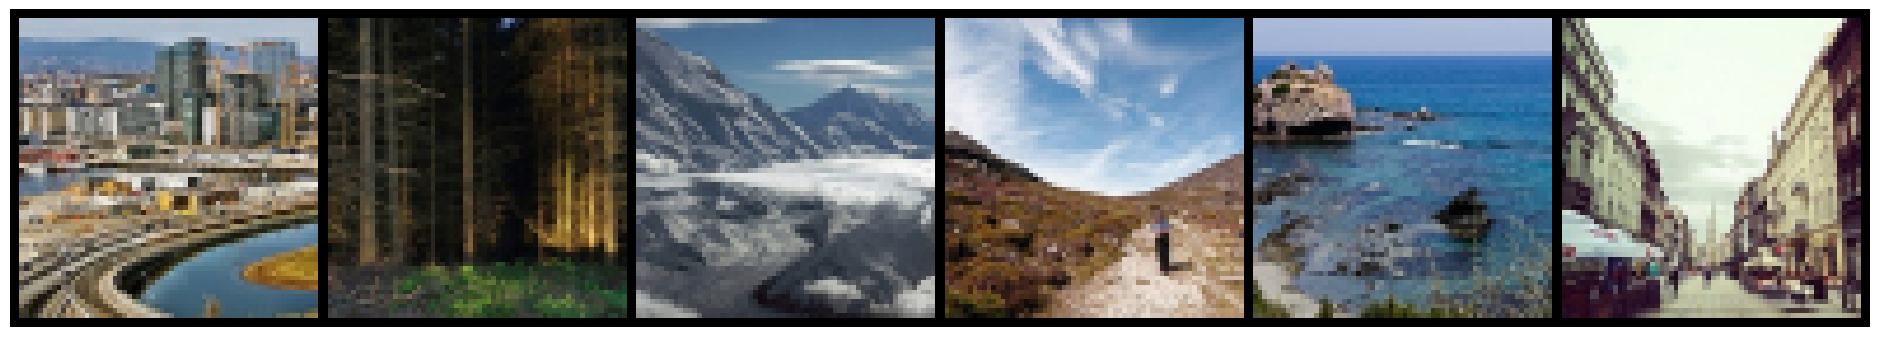

In [25]:
#Show Random Sample Image.
sample_images = [np.random.choice(glob(f'{tf}/*jpg')) for tf in test_folders]
show_sign_grid(sample_images)

### Preprocessing the Test Dataset

In [26]:

#Class Classification.
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

class_indices = [0, 1, 2, 3, 4, 5]

#Test Directory.
DATASETS = ['test']

for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

#Class Distribution & Split.
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{test_folders[cls_index]}/*jpg'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)

    ds_split = np.split(
        image_paths,
        indices_or_sections=[int(.8 * len(image_paths)), int(.9 * len(image_paths))]
    )

    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

#Transforms.
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
    T.Resize(size = 256),
    T.CenterCrop(size= 224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)]),
}

#Image Datasets.
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

#Data Loaders.
data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) for d in DATASETS
}

#Dataset Sizes.
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

buildings: 437
forest: 474
glacier: 553
mountain: 525
sea: 510
street: 501


{'test': 2398}

## Evaluation

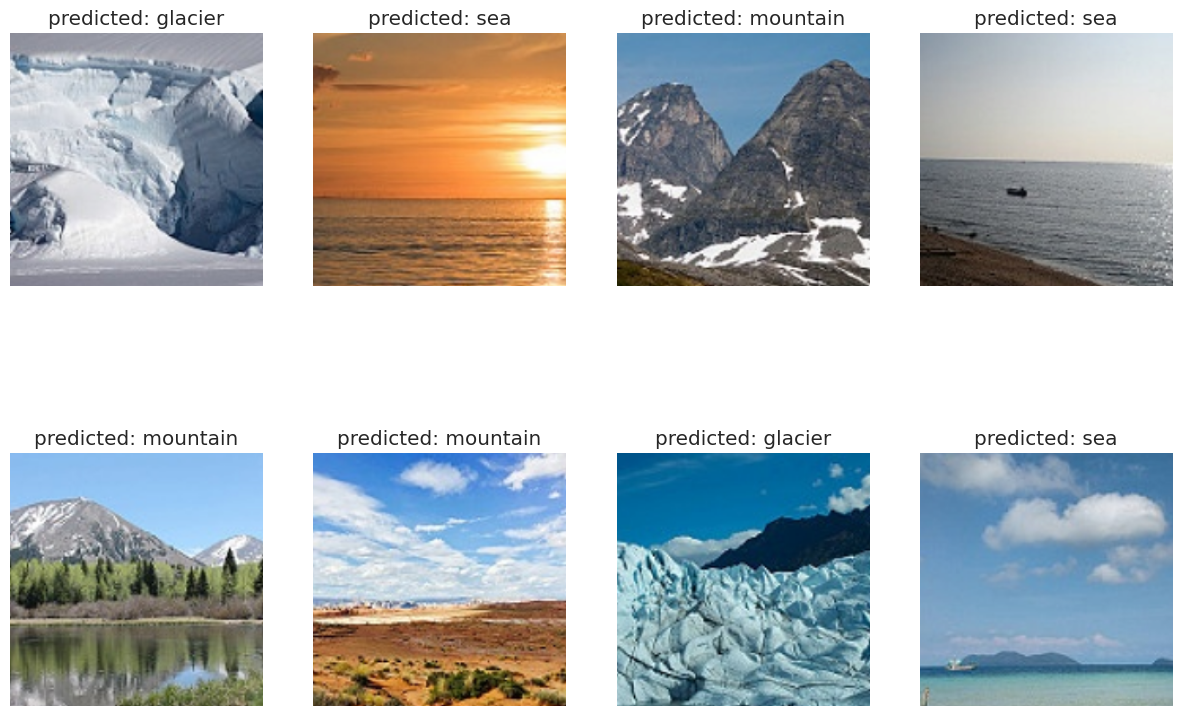

In [27]:
#Show Predictions.
def show_predictions(model, class_names, n_images=6):
    model = model.eval()
    images_handeled = 0
    plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            for j in range(inputs.shape[0]):
                images_handeled += 1
                ax = plt.subplot(2, n_images//2, images_handeled)
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                ax.axis('off')

                if images_handeled == n_images:
                    return

show_predictions(base_model, class_names, n_images=8)

In [28]:
#Classification Report.
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()

    return predictions, real_values

In [29]:
# Testing on unmodified images

y_pred, y_test = get_predictions(base_model, data_loaders['test'])

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.92      0.87      0.90       349
      forest       0.99      0.97      0.98       379
     glacier       0.91      0.82      0.86       442
    mountain       0.86      0.89      0.87       420
         sea       0.90      0.98      0.94       408
      street       0.89      0.94      0.91       400

    accuracy                           0.91      2398
   macro avg       0.91      0.91      0.91      2398
weighted avg       0.91      0.91      0.91      2398



### Adversarial attacks on test dataset

In [30]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [31]:
## Full modified images

def get_predictions_adv(model, data_loader,epsilon):

    model = model.eval()
    predictions = []
    real_values = []
    loss_fn = nn.CrossEntropyLoss().to(device) # Will not be using this


    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        inputs.requires_grad = True

        # Forward pass the data through the model
        outputs = model(inputs)


        # Calculate the loss
        loss = loss_fn(outputs, labels)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = inputs.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(inputs, epsilon, data_grad)

        # Re-classify the perturbed image
        outputs = model(perturbed_data)

        ## New output

        _, preds = torch.max(outputs, dim=1) # get max of pred

        predictions.extend(preds)
        real_values.extend(labels)


    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()

    return predictions, real_values

In [32]:

## Testing model on full modified images

from sklearn.metrics import accuracy_score

epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracy = []

# Run test for each epsilon
for eps in epsilons:
    print("For Epsilon =" +str(eps))
    y_pred, y_test = get_predictions_adv(base_model, data_loaders['test'],eps)

    acc = accuracy_score(y_pred,y_test)
    accuracy.append(acc)

    print(classification_report(y_test, y_pred, target_names=class_names))

For Epsilon =0


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

   buildings       0.58      0.87      0.69       349
      forest       0.98      0.64      0.77       379
     glacier       0.90      0.44      0.59       442
    mountain       0.69      0.63      0.66       420
         sea       0.47      0.96      0.63       408
      street       0.94      0.47      0.62       400

    accuracy                           0.66      2398
   macro avg       0.76      0.67      0.66      2398
weighted avg       0.76      0.66      0.66      2398

For Epsilon =0.05


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

   buildings       0.48      0.77      0.59       349
      forest       0.94      0.57      0.71       379
     glacier       0.62      0.22      0.32       442
    mountain       0.51      0.48      0.50       420
         sea       0.39      0.87      0.54       408
      street       0.78      0.27      0.40       400

    accuracy                           0.52      2398
   macro avg       0.62      0.53      0.51      2398
weighted avg       0.62      0.52      0.50      2398

For Epsilon =0.1


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

   buildings       0.44      0.73      0.55       349
      forest       0.90      0.53      0.67       379
     glacier       0.46      0.16      0.24       442
    mountain       0.43      0.41      0.42       420
         sea       0.37      0.81      0.50       408
      street       0.67      0.21      0.32       400

    accuracy                           0.47      2398
   macro avg       0.54      0.48      0.45      2398
weighted avg       0.54      0.47      0.44      2398

For Epsilon =0.15


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

   buildings       0.43      0.72      0.53       349
      forest       0.85      0.52      0.64       379
     glacier       0.35      0.13      0.19       442
    mountain       0.40      0.38      0.39       420
         sea       0.35      0.77      0.48       408
      street       0.62      0.17      0.27       400

    accuracy                           0.44      2398
   macro avg       0.50      0.45      0.42      2398
weighted avg       0.50      0.44      0.41      2398

For Epsilon =0.2


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

   buildings       0.42      0.70      0.53       349
      forest       0.80      0.51      0.62       379
     glacier       0.31      0.11      0.16       442
    mountain       0.38      0.37      0.38       420
         sea       0.34      0.75      0.47       408
      street       0.57      0.15      0.23       400

    accuracy                           0.42      2398
   macro avg       0.47      0.43      0.40      2398
weighted avg       0.47      0.42      0.39      2398

For Epsilon =0.25


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

   buildings       0.42      0.70      0.53       349
      forest       0.77      0.52      0.62       379
     glacier       0.25      0.08      0.12       442
    mountain       0.36      0.35      0.36       420
         sea       0.33      0.74      0.46       408
      street       0.52      0.13      0.20       400

    accuracy                           0.41      2398
   macro avg       0.44      0.42      0.38      2398
weighted avg       0.44      0.41      0.37      2398

For Epsilon =0.3


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

   buildings       0.44      0.69      0.54       349
      forest       0.75      0.55      0.63       379
     glacier       0.23      0.07      0.10       442
    mountain       0.34      0.34      0.34       420
         sea       0.33      0.74      0.45       408
      street       0.55      0.14      0.22       400

    accuracy                           0.41      2398
   macro avg       0.44      0.42      0.38      2398
weighted avg       0.43      0.41      0.37      2398



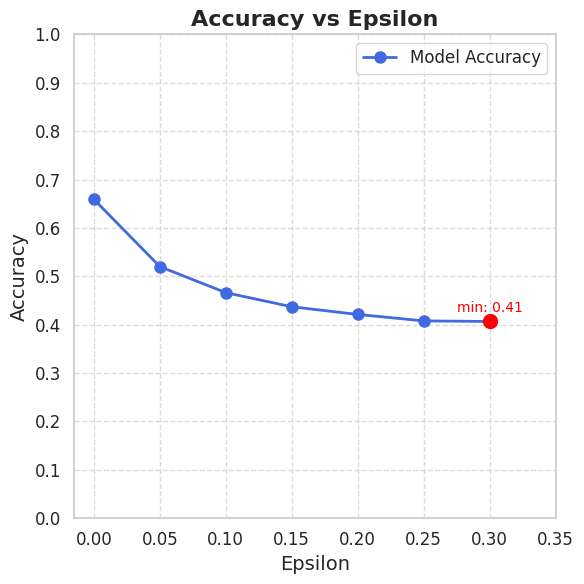

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Apply seaborn style
sns.set(style="whitegrid")

# Example data if not defined
# epsilons = np.arange(0, 0.35, 0.05)
# accuracy = [0.85, 0.83, 0.80, 0.78, 0.75, 0.72, 0.70]

plt.figure(figsize=(6, 6))

# Plot with custom line and marker styles
plt.plot(epsilons, accuracy, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=8, label='Model Accuracy')

# Highlight max accuracy point
min_idx = np.argmin(accuracy)
plt.scatter(epsilons[min_idx], accuracy[min_idx], color='red', s=100, zorder=5)
plt.text(epsilons[min_idx], accuracy[min_idx]+0.02,
         f"min: {accuracy[min_idx]:.2f}", ha='center', fontsize=10, color='red')

# Set axis ticks and labels
plt.xticks(np.arange(0, 0.36, 0.05), fontsize=12)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)
plt.xlabel("Epsilon", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Epsilon", fontsize=16, fontweight='bold')

# Show grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Tight layout and display
plt.tight_layout()
plt.show()
